In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

# Read in data and do basic massaging

In [2]:
df_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_raw.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20
0,NaN,Thailand,15.0,101.0,2,3,5,7,8,8,...,50,50,50,53,59,70,75,82,114,147
1,NaN,Japan,36.0,138.0,2,1,2,2,4,4,...,461,502,511,581,639,639,701,773,839,825


In [3]:
df = df_raw.drop(['Lat', 'Long'], axis=1)                   # drop the Lat/Lon columns
df = df.set_index(['Country/Region', 'Province/State'])     # set index (for rows) to country + state
df = df.stack().unstack(level=[0,1])                        # rotate so country+state is across top and dates go down
df.head(2)

Country/Region Thailand Japan Singapore Nepal Malaysia           Canada  \
Province/State      NaN   NaN       NaN   NaN      NaN British Columbia   
1/22/20               2     2         0     0        0                0   
1/23/20               3     1         1     0        0                0   

Country/Region       Australia                     Cambodia  ... Greenland  \
Province/State New South Wales Victoria Queensland      NaN  ...       NaN   
1/22/20                      0        0          0        0  ...         0   
1/23/20                      0        0          0        0  ...         0   

Country/Region Liberia Mayotte Netherlands Republic of the Congo Somalia  \
Province/State     NaN     NaN     Curacao                   NaN     NaN   
1/22/20              0       0           0                     0       0   
1/23/20              0       0           0                     0       0   

Country/Region Tanzania The Bahamas             US United Kingdom  
Province/State      NaN         NaN Virgin Islands Cayman Islands  
1/22/20               0           0              0              0  
1/23/20               0           0              0              0  

[2 rows x 463 columns]

# Fix the State datasets for CA and NY
Notice that the dataset for US stops reporting at county level on 3/10 and moves to state level. We need to create a merged California dataset with summation of counties before 3/10 and the 'Califorina' column from 3/10 onward

In [6]:
# Notice that the dataset for US stops reporting at county level on 3/10 and moves to state level
idx =  pd.IndexSlice
df.loc['3/7/20':'3/12/20',idx[:,['California', 'Santa Clara County, CA', 'New York', 'Suffolk County, NY']]]

Country/Region       US                                                     
Province/State New York California Suffolk County, NY Santa Clara County, CA
3/7/20                0          0                  0                     32
3/8/20                0          0                  1                     38
3/9/20                0          0                  1                     38
3/10/20             173        144                  0                      0
3/11/20             220        177                  0                      0
3/12/20             328        221                  0                      0

In [7]:
# Create a merged California dataset with summation of counties before 3/10 and the
# 'Califorina' column from 3/10 onward
cal_locations = df.columns.levels[1][df.columns.levels[1].str.contains(", CA")] # get all index entries (counties) ending in ", CA"
cal_locations = list(cal_locations.values)
cal_locations.append('California')                                              # include the 'California' state column to the list
cal_merged = df.loc[:, idx[:, cal_locations]].sum(axis=1)                       # cal_merged is the new California dataset

ny_locations = df.columns.levels[1][df.columns.levels[1].str.contains(", NY")] # get all index entries (counties) ending in ", NY"
ny_locations = list(ny_locations.values)
ny_locations.append('New York')                                              # include the 'New York' state column to the list
ny_merged = df.loc[:, idx[:, ny_locations]].sum(axis=1)                      

cal_merged['3/7/20':'3/12/20']

3/7/20      81
3/8/20      95
3/9/20     101
3/10/20    144
3/11/20    177
3/12/20    221
dtype: int64

# Narrow down to a set of interesting countries plus California and graph

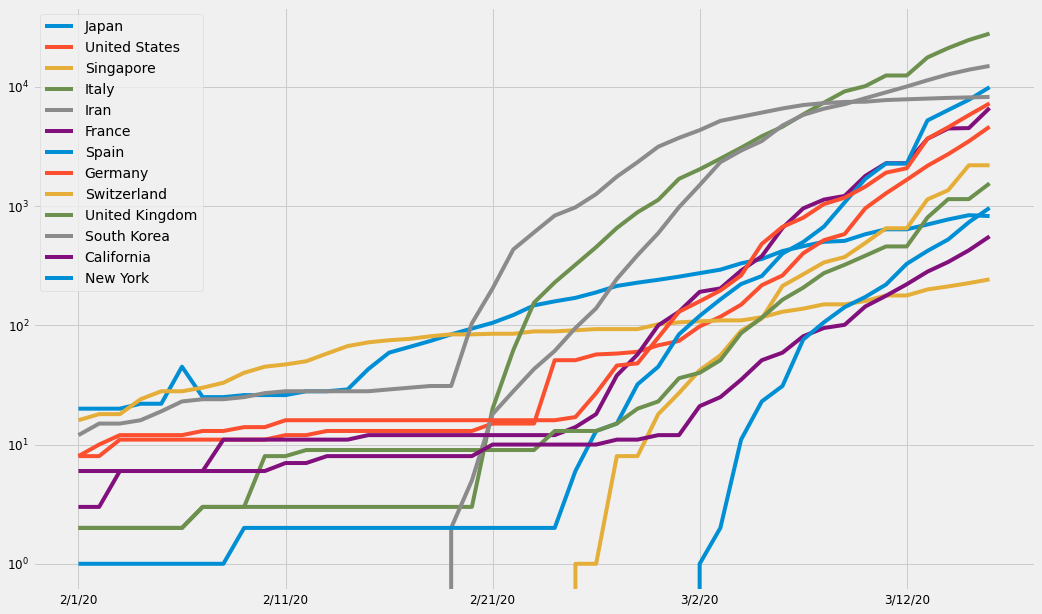

In [23]:
newdf = pd.DataFrame(index = df.index,
                     data = {
                         'Japan': df.loc[:, idx['Japan',:]].sum(axis=1),
                         'United States': df.loc[:, idx['US',:]].sum(axis=1),
                         'Singapore': df.loc[:, idx['Singapore',:]].sum(axis=1),
                         'Italy': df.loc[:, idx['Italy',:]].sum(axis=1),
                         'Iran': df.loc[:, idx['Iran',:]].sum(axis=1),
                         'France': df.loc[:, idx['France',:]].sum(axis=1),
                         'Spain': df.loc[:, idx['Spain',:]].sum(axis=1),
                         'Germany': df.loc[:, idx['Germany',:]].sum(axis=1),
                         'Switzerland': df.loc[:, idx['Switzerland',:]].sum(axis=1),
                         'United Kingdom': df.loc[:, idx['United Kingdom',:]].sum(axis=1),
                         'South Korea': df.loc[:, idx['Korea, South',:]].sum(axis=1),
                         'California': cal_merged,
                         'New York': ny_merged,
                         #'Utah': df.loc[:, idx[:,'Utah']].sum(axis=1),
                         #'Hawaii': df.loc[:, idx[:,'Hawaii']].sum(axis=1),
                     }

)
newdf.loc['2/1/20':,:].plot(logy=True)

# Create a 'days since 100 cases' graph

In [24]:
newdf.head(2)

,Japan,United States,Singapore,Italy,Iran,France,Spain,Germany,Switzerland,United Kingdom,South Korea,California,New York
1/22/20,2,1,0,0,0,0,0,0,0,0,1,0,0
1/23/20,1,1,1,0,0,0,0,0,0,0,1,0,0


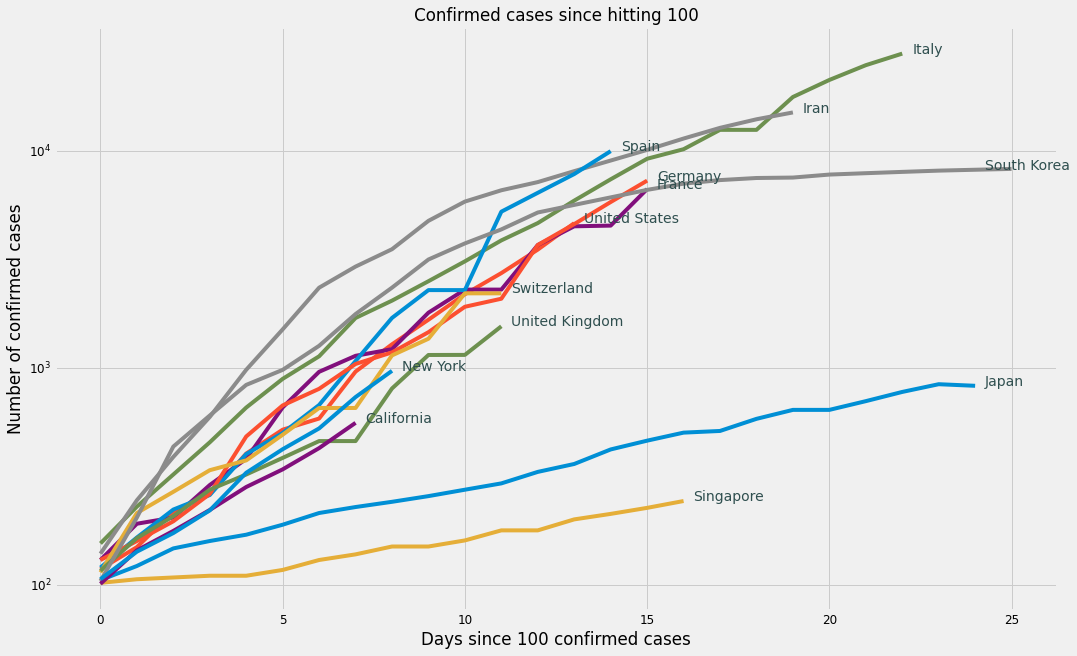

In [25]:
daysSince = 100
daysSince100 = pd.DataFrame(index=range(0,len(newdf.index)))
for location in newdf.columns:
    # create list of data once above 'daysSince'
    tempList = [newdf.loc[date, location] 
                              for date in newdf[location].index 
                              if newdf.loc[date, location] > daysSince]
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSince100.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSince100[location] = tempListFilled
params = {'axes.titlesize':'48',
          'xtick.labelsize':'12',
          'ytick.labelsize':'12',
          'figure.figsize': (16,10),
         }
#plt.rcParams['figure.figsize'] = 32, 20
plt.rcParams.update(params)
daysSince100 = daysSince100.dropna(axis=0, how='all')
ax = daysSince100.plot(logy=True, legend=False)
#ax.set_yscale('log', basey=2)
ax.set_title('Confirmed cases since hitting {}'.format(daysSince), fontsize='large')
ax.set_xlabel('Days since 100 confirmed cases', fontsize='large')
ax.set_ylabel('Number of confirmed cases', fontsize='large')

for location in newdf.columns:
    previous = 100
    for xdays, datapoint in enumerate(daysSince100[location]):
        if pd.isnull(datapoint) or (xdays == len(daysSince100[location])-1):
            ax.annotate(location, (xdays-1, previous), 
                        xytext=(10,0), 
                        textcoords='offset pixels',
                        family='sans-serif', fontsize=14, color='darkslategrey')
            break
        else:
            previous = datapoint
plt.show()
        

In [26]:
daysSince100

,Japan,United States,Singapore,Italy,Iran,France,Spain,Germany,Switzerland,United Kingdom,South Korea,California,New York
0,105.0,118.0,102.0,155.0,139.0,130.0,120.0,130.0,114.0,116.0,104.0,101.0,106.0
1,122.0,149.0,106.0,229.0,245.0,191.0,165.0,159.0,214.0,164.0,204.0,144.0,142.0
2,147.0,217.0,108.0,322.0,388.0,204.0,222.0,196.0,268.0,207.0,433.0,177.0,173.0
3,159.0,262.0,110.0,453.0,593.0,288.0,259.0,262.0,337.0,274.0,602.0,221.0,220.0
4,170.0,402.0,110.0,655.0,978.0,380.0,400.0,482.0,374.0,322.0,833.0,282.0,328.0
5,189.0,518.0,117.0,888.0,1501.0,656.0,500.0,670.0,491.0,384.0,977.0,340.0,421.0
6,214.0,583.0,130.0,1128.0,2336.0,957.0,673.0,799.0,652.0,459.0,1261.0,426.0,525.0
7,228.0,959.0,138.0,1694.0,2922.0,1134.0,1073.0,1040.0,652.0,459.0,1766.0,557.0,732.0
8,241.0,1281.0,150.0,2036.0,3513.0,1217.0,1695.0,1176.0,1139.0,802.0,2337.0,NaN,967.0
9,256.0,1663.0,150.0,2502.0,4747.0,1792.0,2277.0,1457.0,1359.0,1144.0,3150.0,NaN,NaN


# Look at growth factor changes

In [27]:
start_date = '2/27/20'
window = 3
location = ['California', 'Italy']
#location = ['California', 'South Korea', 'Italy', 'Germany', 'New York']
newdf.loc[start_date:,:]

,Japan,United States,Singapore,Italy,Iran,France,Spain,Germany,Switzerland,United Kingdom,South Korea,California,New York
2/27/20,214,58,93,655,245,38,15,46,8,15,1766,11,0
2/28/20,228,60,93,888,388,57,32,48,8,20,2337,11,0
2/29/20,241,68,102,1128,593,100,45,79,18,23,3150,12,0
3/1/20,256,74,106,1694,978,130,84,130,27,36,3736,12,0
3/2/20,274,98,108,2036,1501,191,120,159,42,40,4335,21,1
3/3/20,293,118,110,2502,2336,204,165,196,56,51,5186,25,2
3/4/20,331,149,110,3089,2922,288,222,262,90,86,5621,35,11
3/5/20,360,217,117,3858,3513,380,259,482,114,116,6088,51,23
3/6/20,420,262,130,4636,4747,656,400,670,214,164,6593,59,31
3/7/20,461,402,138,5883,5823,957,500,799,268,207,7041,81,76


In [28]:
# calculate growth factor (diff between 2 points divided by the diff between the prior 2 points)
newdf.loc[start_date:,:].diff().pct_change().add(1)

,Japan,United States,Singapore,Italy,Iran,France,Spain,Germany,Switzerland,United Kingdom,South Korea,California,New York
2/27/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/28/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/29/20,0.928571,4.000000,inf,1.030043,1.433566,2.263158,0.764706,15.500000,inf,0.600000,1.423818,inf,NaN
3/1/20,1.153846,0.750000,0.444444,2.358333,1.878049,0.697674,3.000000,1.645161,0.900000,4.333333,0.720787,0.000000,NaN
3/2/20,1.200000,4.000000,0.500000,0.604240,1.358442,2.033333,0.923077,0.568627,1.666667,0.307692,1.022184,inf,inf
3/3/20,1.055556,0.833333,1.000000,1.362573,1.596558,0.213115,1.250000,1.275862,0.933333,2.750000,1.420701,0.444444,1.000000
3/4/20,2.000000,1.550000,0.000000,1.259657,0.701796,6.461538,1.266667,1.783784,2.428571,3.181818,0.511163,2.500000,9.000000
3/5/20,0.763158,2.193548,inf,1.310051,1.008532,1.095238,0.649123,3.333333,0.705882,0.857143,1.073563,1.600000,1.333333
3/6/20,2.068966,0.661765,1.857143,1.011704,2.087986,3.000000,3.810811,0.854545,4.166667,1.600000,1.081370,0.500000,0.666667
3/7/20,0.683333,3.111111,0.615385,1.602828,0.871961,1.090580,0.709220,0.686170,0.540000,0.895833,0.887129,2.750000,5.625000


In [29]:
# Many countries didn't update their reports on 3/12 leading to 'inf' growth
# factor on 3/13.  I'm going to drop 3/12 data to get a better trend
tempdf = newdf.drop('3/12/20', axis='index')
tempdf.loc[start_date:,:].diff().pct_change().add(1)

,Japan,United States,Singapore,Italy,Iran,France,Spain,Germany,Switzerland,United Kingdom,South Korea,California,New York
2/27/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/28/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2/29/20,0.928571,4.000000,inf,1.030043,1.433566,2.263158,0.764706,15.500000,inf,0.600000,1.423818,inf,NaN
3/1/20,1.153846,0.750000,0.444444,2.358333,1.878049,0.697674,3.000000,1.645161,0.900000,4.333333,0.720787,0.000000,NaN
3/2/20,1.200000,4.000000,0.500000,0.604240,1.358442,2.033333,0.923077,0.568627,1.666667,0.307692,1.022184,inf,inf
3/3/20,1.055556,0.833333,1.000000,1.362573,1.596558,0.213115,1.250000,1.275862,0.933333,2.750000,1.420701,0.444444,1.000000
3/4/20,2.000000,1.550000,0.000000,1.259657,0.701796,6.461538,1.266667,1.783784,2.428571,3.181818,0.511163,2.500000,9.000000
3/5/20,0.763158,2.193548,inf,1.310051,1.008532,1.095238,0.649123,3.333333,0.705882,0.857143,1.073563,1.600000,1.333333
3/6/20,2.068966,0.661765,1.857143,1.011704,2.087986,3.000000,3.810811,0.854545,4.166667,1.600000,1.081370,0.500000,0.666667
3/7/20,0.683333,3.111111,0.615385,1.602828,0.871961,1.090580,0.709220,0.686170,0.540000,0.895833,0.887129,2.750000,5.625000


Text(0.5, 1.0, 'Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n(3 day moving average)')

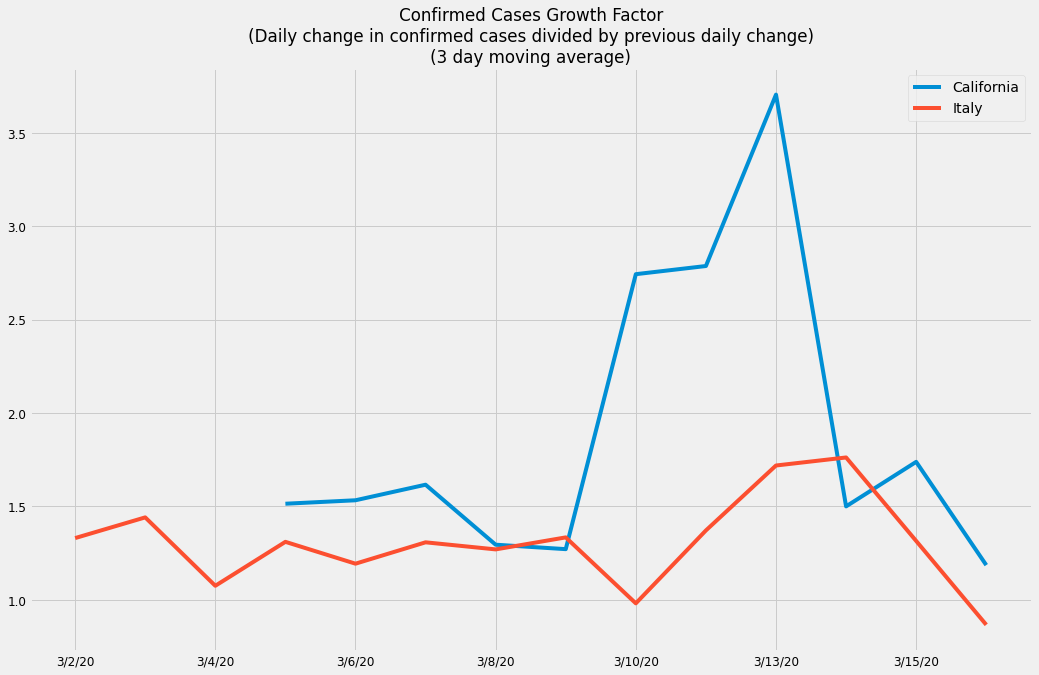

In [30]:
# graph the growth factors
ax = tempdf.loc[start_date:,location].diff().pct_change().add(1).rolling(window).mean().plot()
#ax.set_ylim(ymin=0, ymax=4)
ax.set_title("Confirmed Cases Growth Factor\n(Daily change in confirmed cases divided by previous daily change)\n({} day moving average)".format(window), fontsize='large')